In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.geometry import box as ShapelyBox
from shapely.affinity import rotate, translate
from shapely.prepared import prep
from scipy.ndimage import gaussian_filter

In [89]:
# !pip install shapely

In [3]:
def rectangle_around_slit(x0, y0, lower, upper, slit_vec, normal_vec, half_width, **kwargs):
    """
    Adds a rectangle with half_width around the slit defined by lower/upper range and two vectors.
    """
    x1 = x0-1*slit_vec[0]*lower
    x2 = x0+1*slit_vec[0]*upper
    y1 = y0-1*slit_vec[1]*lower
    y2 = y0+1*slit_vec[1]*upper

    # Half width offset
    ox = half_width * normal_vec[0]
    oy = half_width * normal_vec[1]

    # Rectangle corners
    
    corner1 = (x1 + ox, y1 + oy)
    corner2 = (x2 + ox, y2 + oy)
    corner3 = (x2 - ox, y2 - oy)
    corner4 = (x1 - ox, y1 - oy)

    # Create and add polygon patch
    return Polygon([corner1, corner2, corner3, corner4], closed=True, **kwargs)
    


In [4]:
def make_slit_polygon_vector(center_x, center_y, slit_vec, normal_vec, lower, upper, half_width):
    """
    Return 4 corners of the tilted rectangle slit centered at (center_x, center_y).
    """
    center_x+=0.5
    center_y+=0.5
    p1 = [center_x, center_y] + (-half_width * normal_vec - lower * slit_vec)
    p2 = [center_x, center_y] + ( half_width * normal_vec - upper * slit_vec)
    p3 = [center_x, center_y] + ( half_width * normal_vec + upper * slit_vec)
    p4 = [center_x, center_y] + (-half_width * normal_vec + lower * slit_vec)
    return np.array([p1, p2, p3, p4])

In [5]:

def compute_overlap_weights(slit_polygon, x_min, x_max, y_min, y_max):
    """
    Compute the overlap area between a slit polygon and all pixels in a region.
    Returns:
        - pixel_xs, pixel_ys: integer grid coordinates of pixels
        - areas: corresponding overlap area (same shape)
    """
    pixel_xs, pixel_ys = np.meshgrid(np.arange(x_min, x_max),
                                     np.arange(y_min, y_max),
                                     indexing='xy')
    pixel_xs = pixel_xs.flatten()
    pixel_ys = pixel_ys.flatten()

    areas = np.zeros_like(pixel_xs, dtype=np.float32)

    for i, (x, y) in enumerate(zip(pixel_xs, pixel_ys)):
        # pixel_poly = ShapelyBox(x - 0.5, y - 0.5, x + 0.5, y + 0.5)
        pixel_poly = ShapelyBox(x, y, x + 1, y + 1)
        intersection = slit_polygon.intersection(pixel_poly)
        if not intersection.is_empty:
            areas[i] = intersection.area

    return pixel_xs, pixel_ys, areas

In [6]:
def tilted_slit_extraction(frame, trace_x, trace_y, tilt_array,
                           lower, upper,
                           oversample_y=1, oversample_x=1):
    """
    Extract 1D spectrum from 2D frame using tilted slit extraction.

    Parameters
    ----------
    frame : 2D numpy array
        Input image data.
    trace_x, trace_y : 1D arrays
        Trace coordinates. trace_y is dispersion axis indices,
        trace_x is spatial coordinate at each y.
    tilt_array : 1D array
        Slit tilt at each y (slope dy/dx or a in y = a*x).
    lower, upper : scalar ints
        Pixel range around trace_x to include in spatial direction.
    oversample_y, oversample_x : int
        Oversampling factors for dispersion and spatial directions.

    Returns
    -------
    spectrum : 1D array
        Extracted spectrum of length len(trace_y).
    """

    ny, nx = frame.shape
    spectrum = np.zeros(len(trace_y), dtype=np.float64)

    # Pixel size in both directions (1 pix by default)
    pix_size_x = 1 / oversample_x
    pix_size_y = 1 / oversample_y

    # Loop over dispersion coordinate (y)
    for idx_y, y0 in enumerate(trace_y):
        # Oversampled positions in y around y0
        y_os_vals = np.linspace(y0, y0 + 1, oversample_y, endpoint=False) if oversample_y > 1 else [y0]

        flux_os = 0.0
        weight_os = 0.0

        for y_os in y_os_vals:
            # Interpolate trace_x and tilt at y_os
            x0 = np.interp(y_os, trace_y, trace_x)
            tilt = np.interp(y_os, trace_y, tilt_array)

            # Slit width in pixels (spatial)
            slit_width = lower + upper

            # Compute slit vector angle in degrees for shapely rotation
            angle_deg = np.degrees(np.arctan(tilt))  # tilt = dy/dx

            # Build slit polygon (rectangle) centered at (x0, y_os)
            # rectangle width = slit_width in x direction, height = pixel size in y
            slit_rect = ShapelyBox(-lower, -0.5*pix_size_y, upper, 0.5*pix_size_y)

            # Rotate slit polygon by angle_deg around origin
            slit_rotated = rotate(slit_rect, angle_deg, origin=(0, 0), use_radians=False)

            # Translate to center at (x0, y_os)
            slit_poly = translate(slit_rotated, xoff=x0, yoff=y_os)

            # Determine pixel bounding box indices (integer)
            minx, miny, maxx, maxy = slit_poly.bounds
            ix_min = max(int(np.floor(minx - 1)), 0)
            ix_max = min(int(np.ceil(maxx + 1)), nx - 1)
            iy_min = max(int(np.floor(miny - 1)), 0)
            iy_max = min(int(np.ceil(maxy + 1)), ny - 1)

            # Sum weighted flux over pixels overlapping with slit_poly
            flux_sum = 0.0
            weight_sum = 0.0

            for ix in range(ix_min, ix_max + 1):
                for iy in range(iy_min, iy_max + 1):
                    # Pixel polygon at pixel center
                    pixel_poly = ShapelyBox(ix - 0.5, iy - 0.5, ix + 0.5, iy + 0.5)

                    # Compute overlap area
                    overlap_area = slit_poly.intersection(pixel_poly).area

                    if overlap_area > 0:
                        flux_sum += frame[iy, ix] * overlap_area
                        weight_sum += overlap_area

            if weight_sum > 0:
                flux_os += flux_sum / weight_sum
                weight_os += 1.0

        # Average oversampled flux (if oversampled in y)
        spectrum[idx_y] = flux_os / weight_os if weight_os > 0 else 0.0

    return spectrum


In [7]:
def extract_spectrum_polygon_overlap(frame, trace_x, trace_y, tilt_array,
                                     lower, upper,
                                     slit_half_width=0.5):
    """
    Accurate extraction using polygon overlaps (area-based weighting).

    Parameters
    ----------
    frame : 2D array (ny, nx)
    trace_x, trace_y : arrays defining trace
    tilt_array : slopes dy/dx at each trace point
    lower, upper : spatial bounds (in pixels) along cross-dispersion (x)
    slit_half_width : half-width of slit in pixels

    Returns
    -------
    extracted_flux : 1D array, same length as trace
    """
    ny, nx = frame.shape
    extracted_flux = np.zeros_like(trace_y)

    for i, (x0, y0, tilt) in enumerate(zip(trace_x, trace_y, tilt_array)):
        theta = np.arctan(tilt)
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)

        # Define slit rectangle corners
        dx = upper + lower
        dy = 2 * slit_half_width

        # Centered slit rectangle (before rotation)
        corners = np.array([
            [-lower, -slit_half_width],
            [upper, -slit_half_width],
            [upper, slit_half_width],
            [-lower, slit_half_width]
        ])

        # Rotate and translate slit to (x0, y0)
        R = np.array([[cos_t, -sin_t], [sin_t, cos_t]])
        rotated = corners @ R.T + np.array([x0, y0])
        slit_poly = Polygon(rotated)

        if not slit_poly.is_valid:
            extracted_flux[i] = 0
            continue

        # Compute bounding box of slit to define pixel window
        minx, miny, maxx, maxy = slit_poly.bounds
        ix_min = max(int(np.floor(minx)), 0)
        ix_max = min(int(np.ceil(maxx)) + 1, nx)
        iy_min = max(int(np.floor(miny)), 0)
        iy_max = min(int(np.ceil(maxy)) + 1, ny)

        # Vectorized creation of pixel boxes
        x_grid, y_grid = np.meshgrid(np.arange(ix_min, ix_max),
                                     np.arange(iy_min, iy_max))
        pixel_x = x_grid.ravel()
        pixel_y = y_grid.ravel()

        pixel_boxes = [ShapelyBox(x, y, x + 1, y + 1) for x, y in zip(pixel_x, pixel_y)]

        # Precompile slit polygon for fast intersection
        slit_prep = prep(slit_poly)

        weights = []
        fluxes = []

        for (x, y, pix_box) in zip(pixel_x, pixel_y, pixel_boxes):
            if not slit_prep.intersects(pix_box):
                continue
            overlap = slit_poly.intersection(pix_box).area
            if overlap > 0:
                weights.append(overlap)
                fluxes.append(frame[y, x])

        weights = np.array(weights)
        fluxes = np.array(fluxes)

        if weights.sum() > 0:
            extracted_flux[i] = np.sum(weights * fluxes) / weights.sum()
        else:
            extracted_flux[i] = 0

    return extracted_flux


In [9]:
%matplotlib widget

array('d', [25.514996501099624, 25.495000499900023, 75.48500349890037, 75.50499950009998, 25.514996501099624]) array('d', [49.500199940019996, 50.5, 51.499800059980004, 50.5, 49.500199940019996])


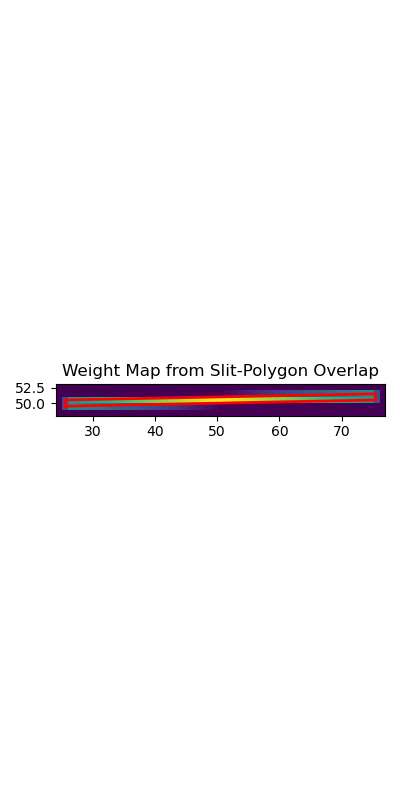

In [12]:
# Slit parameters
center_x, center_y = 50, 50  # Center in continuous space
slope = 0.02
lower = 25
upper = 25
half_width = 0.5

# Compute slit and normal vectors
slit_vec = np.array([1.0, slope])
slit_vec /= np.linalg.norm(slit_vec)
normal_vec = np.array([-slope, 1.0])
normal_vec /= np.linalg.norm(normal_vec)

slit = make_slit_polygon_vector(center_x, center_y, slit_vec, normal_vec, lower, upper, half_width)
slit_polygon = ShapelyPolygon(slit)

# Define bounding box around the slit
bounds = slit_polygon.bounds
x_min = int(np.floor(bounds[0])) - 1
x_max = int(np.ceil(bounds[2])) + 1
y_min = int(np.floor(bounds[1])) - 1
y_max = int(np.ceil(bounds[3])) + 1

# Compute overlap weights
px, py, weights = compute_overlap_weights(slit_polygon, x_min, x_max, y_min, y_max)

# Plotting
fig, ax = plt.subplots(figsize=(4, 8))
# norm = Normalize(vmin=0, vmax=1.0)
# cmap = plt.cm.viridis

# for x, y, w in zip(px, py, weights):
#     if w > 0:
#         rect = Rectangle((x, y), 1, 1, facecolor=cmap(norm(w)), edgecolor='k', linewidth=0.1)
#         ax.add_patch(rect)

ax.imshow(weights.reshape(y_max-y_min, x_max-x_min), origin='lower', extent=[x_min, x_max, y_min, y_max])

x_slit, y_slit = slit_polygon.exterior.xy
print(x_slit, y_slit)
ax.plot(x_slit, y_slit, color='red', linewidth=2)

# sm = ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# plt.colorbar(sm, ax=ax, label='Overlap Area', orientation='horizontal')
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.set_title("Weight Map from Slit-Polygon Overlap")
plt.tight_layout()
plt.show()


In [ ]:

p1 = [center_x, center_y] + (-half_width * normal_vec - lower * slit_vec)
p2 = [center_x, center_y] + ( half_width * normal_vec - upper * slit_vec)
p3 = [center_x, center_y] + ( half_width * normal_vec + upper * slit_vec)
p4 = [center_x, center_y] + (-half_width * normal_vec + lower * slit_vec)

In [ ]:
# pixel = box(x - 0.5, y - 0.5, x + 0.5, y + 0.5)
# area = slit_polygon.intersection(pixel).area

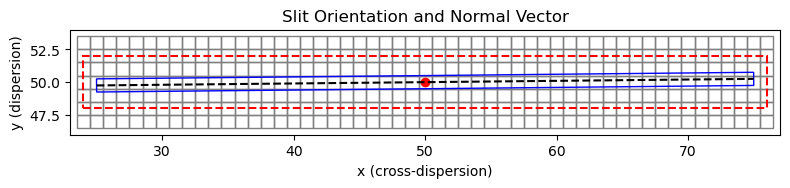

In [67]:
# Parameters
x0, y0 = 50, 50  # center of the slit
slope = 0.01     # slit tilt
lower = 25        # pixels below center
upper = 25        # pixels above center
N = 5 # subpixels
half_width = 0.5

# Vectors
slit_vec = np.array([1, slope])
slit_vec /= np.linalg.norm(slit_vec)
normal_vec = np.array([-slope, 1])
normal_vec /= np.linalg.norm(normal_vec)

# Grid range
x_range = np.arange(x0 - lower-1, x0 + upper+2)
y_range = np.arange(y0 - 3, y0 + 4)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
ax.set_xlim(x_range[0] - 1, x_range[-1] + 1)
# ax.set_xlim(x_range[0], x_range[0] + 2)
ax.set_ylim(y_range[0] - 1, y_range[-1] + 1)
# ax.set_ylim(y0-2, y0+1)
# ax.invert_yaxis()
ax.set_title("Slit Orientation and Normal Vector")

# Draw pixel grid
for x in x_range:
    for y in y_range:
        ax.add_patch(Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor='gray', facecolor='none'))
        # subpixel_size = 1.0 / N  # Size of each subpixel
        # for i in range(N):
        #     for j in range(N):
        #         sub_x = x - 0.5 + i * subpixel_size
        #         sub_y = y - 0.5 + j * subpixel_size
        #         ax.add_patch(Rectangle(
        #             (sub_x, sub_y),
        #             subpixel_size,
        #             subpixel_size,
        #             edgecolor='lightgray',
        #             facecolor='none',
        #             linewidth=0.5  # Thinner line for subpixels
        #         ))

# Slit center
ax.plot(x0, y0, 'ro', label='Slit Center')

# Slit and normal arrows
ax.plot([x0-1*slit_vec[0]*lower, x0+1*slit_vec[0]*upper], [y0-1*slit_vec[1]*lower, y0+1*slit_vec[1]*upper], 'k--')
# ax.arrow(x0, y0, slit_vec[0]*2, slit_vec[1]*2, color='blue', width=0.1, label='Slit Direction')
# ax.arrow(x0, y0, normal_vec[0]*2, normal_vec[1]*2, color='green', width=0.1, label='Normal Direction')

# Slit limits
# for offset in [-lower, upper]:
#     x_edge = x0 + offset * normal_vec[0]
#     y_edge = y0 + offset * normal_vec[1]
#     ax.plot([x0, x_edge], [y0, y_edge], 'k--')

# Bounding box
x_min = int(np.floor(x0 - lower)) - 1
x_max = int(np.ceil(x0 + upper)) + 1
y_min = int(np.floor(y0 - abs(slope)*lower)) - 1
y_max = int(np.ceil(y0 + abs(slope)*upper)) + 1
# rect = Rectangle((x_min - 0.5, y_min - 0.5), x_max - x_min + 1, y_max - y_min + 1, 
#                  edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='Cutout Region')
rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                 edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='Cutout Region')
ax.add_patch(rect)

# polygon_kwargs = 
slit = make_slit_polygon_vector(x0, y0, slit_vec, normal_vec, lower, upper, half_width)
slit_polygon = Polygon(slit, closed=True, facecolor='None', edgecolor='blue')
# slit = rectangle_around_slit(x0, y0, lower, upper, slit_vec, normal_vec, 0.5, facecolor='None', edgecolor='blue')
ax.add_patch(slit_polygon)

# Final touches
# ax.legend(loc='upper right')
# plt.grid(True)
plt.xlabel("x (cross-dispersion)")
plt.ylabel("y (dispersion)")
plt.tight_layout()
plt.show()


In [60]:
slit

array([[49.7500125 , 24.99625016],
       [49.2500375 , 74.99375034],
       [50.2499875 , 75.00374984],
       [50.7499625 , 25.00624966]])

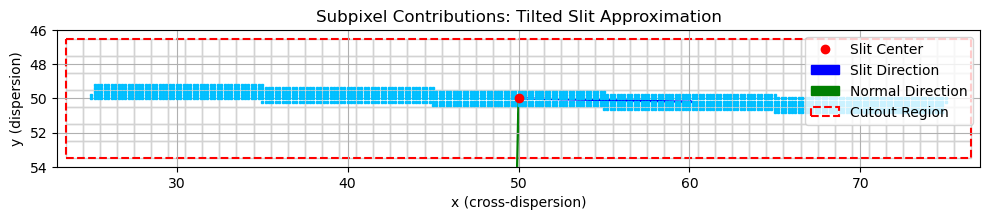

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Parameters
x0, y0 = 50, 50
slope = 0.02
lower = 25
upper = 25
subsample = 5  # Subpixels per pixel side

# Vectors
slit_vec = np.array([1, slope])
slit_vec /= np.linalg.norm(slit_vec)
normal_vec = np.array([-slope, 1])
normal_vec /= np.linalg.norm(normal_vec)

# Region of interest
x_min = int(np.floor(x0 - lower)) - 1
x_max = int(np.ceil(x0 + upper)) + 1
y_min = int(np.floor(y0 - abs(slope)*lower)) - 2
y_max = int(np.ceil(y0 + abs(slope)*upper)) + 2

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_xlim(x_min - 1, x_max + 1)
ax.set_ylim(y_min - 1, y_max + 1)
ax.invert_yaxis()
ax.set_title("Subpixel Contributions: Tilted Slit Approximation")

# Draw pixel grid
for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        ax.add_patch(Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor='lightgray', facecolor='none'))

# Subpixel logic
for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        for i in range(subsample):
            for j in range(subsample):
                x_sub = x + (i + 0.5) / subsample - 0.5
                y_sub = y + (j + 0.5) / subsample - 0.5
                dx = x_sub - x0
                dy = y_sub - y0
                d_slit = dx * slit_vec[0] + dy * slit_vec[1]
                d_normal = dx * normal_vec[0] + dy * normal_vec[1]
                if -lower <= d_slit <= upper and -0.5 <= d_normal <= 0.5:
                    ax.plot(x_sub, y_sub, 's', color='deepskyblue', markersize=2)

# Vectors
ax.plot(x0, y0, 'ro', label='Slit Center')
ax.arrow(x0, y0, slit_vec[0]*10, slit_vec[1]*10, color='blue', width=0.05, label='Slit Direction')
ax.arrow(x0, y0, normal_vec[0]*10, normal_vec[1]*10, color='green', width=0.05, label='Normal Direction')

# Cutout
rect = Rectangle((x_min - 0.5, y_min - 0.5), x_max - x_min + 1, y_max - y_min + 1,
                 edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='Cutout Region')
ax.add_patch(rect)

ax.legend(loc='upper right')
plt.xlabel("x (cross-dispersion)")
plt.ylabel("y (dispersion)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
%matplotlib widget

RuntimeError: 'widget is not a recognised GUI loop or backend name

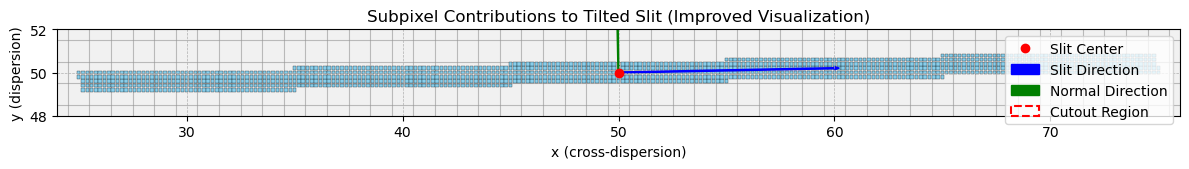

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Parameters
x0, y0 = 50, 50
slope = 0.02
lower = 25
upper = 25
subsample = 5  # Subpixels per pixel side

# Vectors
slit_vec = np.array([1, slope])
slit_vec /= np.linalg.norm(slit_vec)
normal_vec = np.array([-slope, 1])
normal_vec /= np.linalg.norm(normal_vec)

# Region of interest
x_min = int(np.floor(x0 - lower)) - 1
x_max = int(np.ceil(x0 + upper)) + 1
y_min = int(np.floor(y0 - abs(slope)*max(lower, upper))) - 1
y_max = int(np.ceil(y0 + abs(slope)*max(lower, upper))) + 1

# Create plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# ax.invert_yaxis()
ax.set_title("Subpixel Contributions to Tilted Slit (Improved Visualization)")

# Draw pixel grid
for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        ax.add_patch(Rectangle((x - 0.5, y - 0.5), 1, 1,
                               edgecolor='gray', facecolor='lightgray', linewidth=0.8, alpha=0.3))

# Subpixel size
subpixel_size = 1 / subsample * 0.8

# Mark contributing subpixels
for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        for i in range(subsample):
            for j in range(subsample):
                x_sub = x + (i + 0.5) / subsample - 0.5
                y_sub = y + (j + 0.5) / subsample - 0.5
                dx = x_sub - x0
                dy = y_sub - y0
                d_slit = dx * slit_vec[0] + dy * slit_vec[1]
                d_normal = dx * normal_vec[0] + dy * normal_vec[1]
                if -lower <= d_slit <= upper and -0.5 <= d_normal <= 0.5:
                    ax.add_patch(Rectangle(
                        (x_sub - subpixel_size / 2, y_sub - subpixel_size / 2),
                        subpixel_size, subpixel_size,
                        facecolor='skyblue', edgecolor='black', linewidth=0.2))

# Draw center and direction vectors
ax.plot(x0, y0, 'ro', label='Slit Center')
ax.arrow(x0, y0, slit_vec[0]*10, slit_vec[1]*10, color='blue', width=0.05, label='Slit Direction')
ax.arrow(x0, y0, normal_vec[0]*10, normal_vec[1]*10, color='green', width=0.05, label='Normal Direction')

# Cutout region
rect = Rectangle((x_min - 0.5, y_min - 0.5), x_max - x_min + 1, y_max - y_min + 1,
                 edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='Cutout Region')
ax.add_patch(rect)

# Final touches
ax.legend(loc='upper right')
plt.xlabel("x (cross-dispersion)")
plt.ylabel("y (dispersion)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


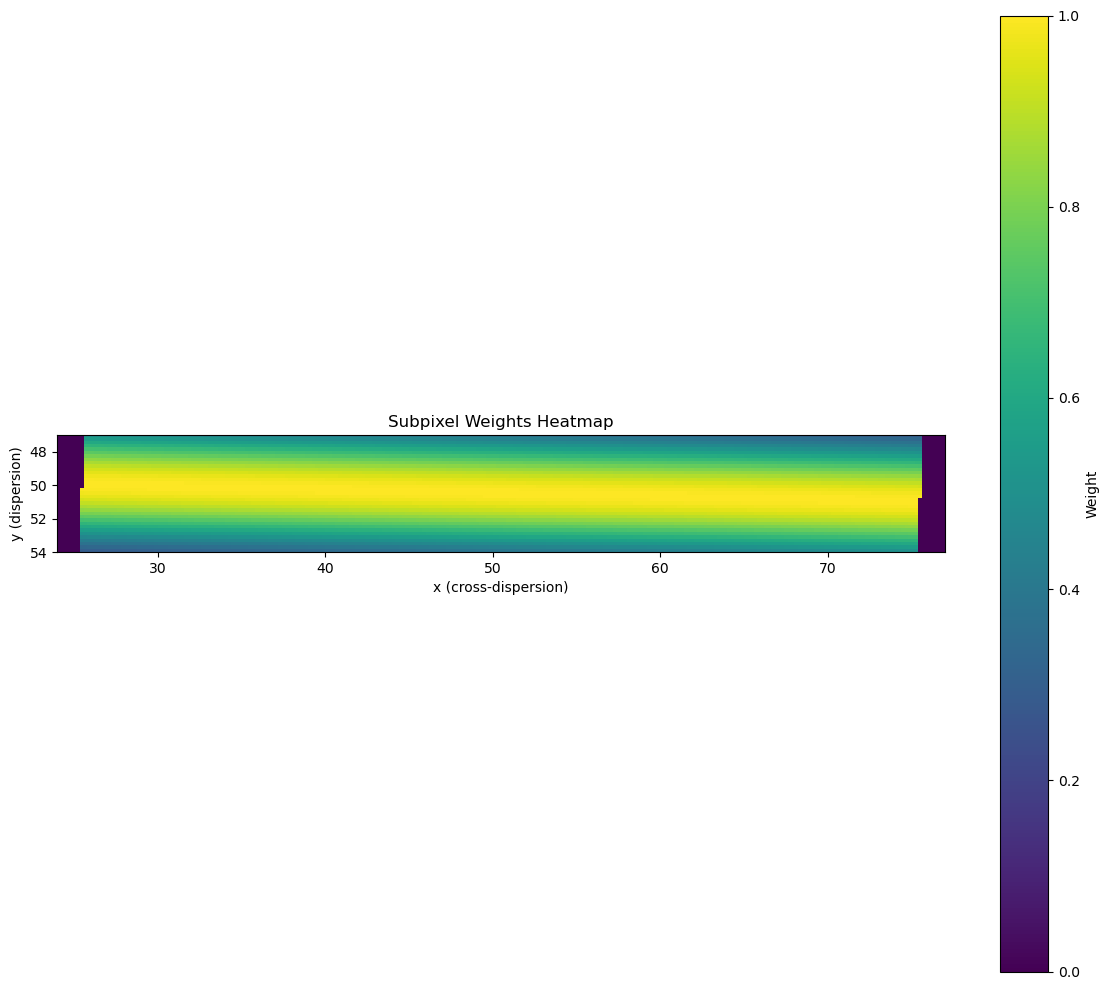

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Parameters
x0, y0 = 50, 50
slope = 0.02
lower = 25
upper = 25
subsample = 5  # Subpixels per pixel side
pixel_sigma=2.5

# Define vectors
slit_vec = np.array([1.0, slope])
slit_vec /= np.linalg.norm(slit_vec)
normal_vec = np.array([-slope, 1.0])
normal_vec /= np.linalg.norm(normal_vec)

# Define region of interest
x_min = int(np.floor(x0 - lower)) - 1
x_max = int(np.ceil(x0 + upper)) + 1
y_min = int(np.floor(y0 - abs(slope) * lower)) - 2
y_max = int(np.ceil(y0 + abs(slope) * upper)) + 2

# Create grid for weight accumulation
grid_width = x_max - x_min + 1
grid_height = y_max - y_min + 1
weight_grid = np.zeros((grid_height * subsample, grid_width * subsample))

# Calculate weights for each subpixel
for xi in range(x_min, x_max + 1):
    for yi in range(y_min, y_max + 1):
        for i in range(subsample):
            for j in range(subsample):
                x_sub = xi + (i + 0.5) / subsample - 0.5
                y_sub = yi + (j + 0.5) / subsample - 0.5

                dx = x_sub - x0
                dy = y_sub - y0
                d_slit = dx * slit_vec[0] + dy * slit_vec[1]
                d_normal = dx * normal_vec[0] + dy * normal_vec[1]

                if -lower <= d_slit <= upper:
                    weight = np.exp(-0.5 * (d_normal / pixel_sigma) ** 2)  # Gaussian weight
                    x_idx = (xi - x_min) * subsample + i
                    y_idx = (yi - y_min) * subsample + j
                    weight_grid[y_idx, x_idx] = weight

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
extent = [x_min, x_max + 1, y_max + 1, y_min]  # Flip y for image coordinates
c = ax.imshow(weight_grid, extent=extent, cmap='viridis', interpolation='nearest', aspect='equal')
ax.set_title("Subpixel Weights Heatmap")
ax.set_xlabel("x (cross-dispersion)")
ax.set_ylabel("y (dispersion)")
fig.colorbar(c, ax=ax, label="Weight")
plt.tight_layout()
plt.show()


In [ ]:
def make_slit_rectangle(center_x, center_y, width, height, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    dx = width / 2
    dy = height / 2

    # Rectangle corners before rotation (centered at origin)
    corners = np.array([
        [-dx, -dy],
        [ dx, -dy],
        [ dx,  dy],
        [-dx,  dy]
    ])

    # Rotation matrix
    R = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])

    # Rotate and translate
    rotated = (R @ corners.T).T + np.array([center_x, center_y])
    return rotated

# Example inputs
x_c, y_c = 50, 50
slit_width = 50   # cross-dispersion (e.g. lower+upper)
slit_height = 1.0  # small height in dispersion direction
slope = 0.02
angle_deg = np.rad2deg(np.arctan(slope))

# Create slit polygon
slit_poly = make_slit_rectangle(x_c, y_c, slit_width, slit_height, angle_deg)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.add_patch(Polygon(slit_poly, closed=True, facecolor='r', alpha=0.3, edgecolor='k'))

# Draw pixel grid
x_range = np.arange(int(x_c - slit_width/2) - 1, int(x_c + slit_width/2) + 2)
y_range = np.arange(int(y_c - 2), int(y_c + 3))
for x in x_range:
    for y in y_range:
        ax.add_patch(Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor='black', facecolor='none', lw=0.5))

ax.set_xlim(x_c - slit_width / 2 - 2, x_c + slit_width / 2 + 2)
ax.set_ylim(y_c - 3, y_c + 3)
ax.set_aspect('equal')
ax.set_title("Tilted Slit Rectangle Over Pixel Grid")
plt.grid(True)
plt.show()